## Import Statements

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


# Read and Clean the Data

In [7]:
df = pd.read_csv("outputs/merged_def.csv")  # or use your DataFrame directly

# Handle missing values if any
df = df.dropna(subset=['drtgPlayer'])  # Drop rows with no target
df.fillna(0, inplace=True)  # Replace remaining NaNs with 0
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 917 entries, 0 to 974
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  917 non-null    int64  
 1   Player      917 non-null    object 
 2   Team        917 non-null    object 
 3   Conf        917 non-null    object 
 4   height      917 non-null    float64
 5   mpg         917 non-null    float64
 6   gp          917 non-null    float64
 7   drtgPlayer  917 non-null    float64
 8   ortgPlayer  917 non-null    float64
 9   ws          917 non-null    float64
 10  ows         917 non-null    float64
 11  dws         917 non-null    float64
 12  rapm        917 non-null    float64
 13  orapm       917 non-null    float64
 14  drapm       917 non-null    float64
 15  stl         917 non-null    float64
 16  blk         917 non-null    float64
 17  stlPg       917 non-null    float64
 18  blkPg       917 non-null    float64
 19  Poss        917 non-null    float6

## Feature Selection

In [5]:
features = [
    'height', 'mpg', 'gp', 'TeamDefRtg', 'ortgPlayer', 'ws', 'ows', 'dws',
    'rapm', 'orapm', 'drapm', 'stl', 'blk', 'stlPg', 'blkPg', 'Poss',
    'PPP', 'PPS'
]
target = 'drtgPlayer'


## Train/Test Split

In [8]:
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Random Forest Model Training

In [9]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

### Model Evaluation 

In [10]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")


RMSE: 2.99
R^2 Score: 0.85


### cross validation

In [11]:
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"Mean CV R^2: {cv_scores.mean():.2f}")


Mean CV R^2: 0.83


## Feature Importance

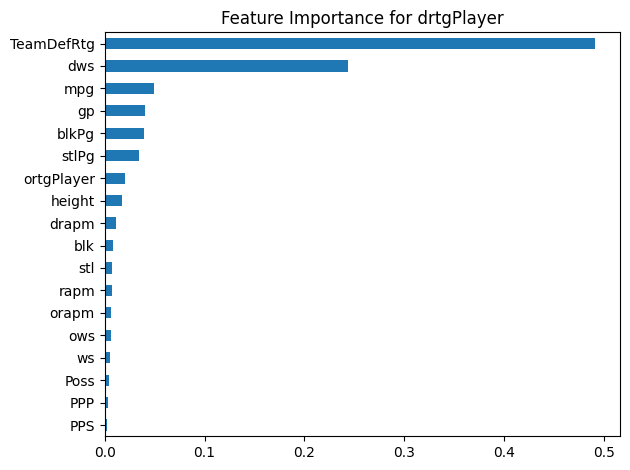

TeamDefRtg: 0.49
dws: 0.24
mpg: 0.05
gp: 0.04
blkPg: 0.04
stlPg: 0.03
ortgPlayer: 0.02
height: 0.02
drapm: 0.01
blk: 0.01
stl: 0.01
rapm: 0.01
orapm: 0.01
ows: 0.01
ws: 0.01
Poss: 0.00
PPP: 0.00
PPS: 0.00


In [15]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

feat_imp.plot(kind='barh', title='Feature Importance for drtgPlayer')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
# Print feature importances with feature names
sorted_indices = importances.argsort()[::-1]
for idx in sorted_indices:
    print(f"{features[idx]}: {importances[idx]:.2f}")


In [16]:
# Covariance matrix between features
cov_matrix = df[features].cov()
print("Covariance Matrix:")
print(cov_matrix)

# Correlation matrix between features and target
corr_matrix = df[features + [target]].corr()
print("\nCorrelation Matrix (features with target):")
print(corr_matrix[target].sort_values(ascending=False))

Covariance Matrix:
               height         mpg          gp  TeamDefRtg  ortgPlayer  \
height      14.044125   -2.991576    0.528247   -8.317879    3.885599   
mpg         -2.991576  104.795498   58.477048    1.149282  172.615019   
gp           0.528247   58.477048   84.754939   -3.741319  163.615133   
TeamDefRtg  -8.317879    1.149282   -3.741319  637.871183  -23.664808   
ortgPlayer   3.885599  172.615019  163.615133  -23.664808  935.474108   
ws           0.254796   11.419651    8.065768   -2.586042   27.070369   
ows          0.089430    7.136256    4.631823    0.322256   17.995761   
dws          0.164612    4.245898    3.403391   -2.912192    8.809550   
rapm         0.089696    7.625058    4.900173   -5.307610   22.727401   
orapm       -0.070289    6.002782    3.525632    0.743679   17.558027   
drapm        0.160137    1.623782    1.375029   -6.056980    5.178382   
stl         -8.799934  140.114979   98.491662  -16.609558  236.099395   
blk         13.357760   47.26907

In [26]:
import numpy as np
import pandas as pd

# Assuming 'cov_matrix' is your covariance matrix
cov_matrix = pd.DataFrame(cov_matrix)  # Your matrix here

# 1. Convert to correlation
std_devs = np.sqrt(np.diag(cov_matrix))
correlation_matrix = cov_matrix / np.outer(std_devs, std_devs)

# 2. Flag high correlations
significant_correlations = correlation_matrix.abs() > 0.3
significant_pairs = correlation_matrix[significant_correlations].stack().dropna()

# 3. Multicollinearity check
high_vif_vars = []
for col in cov_matrix.columns:
    vif = 1 / (1 - correlation_matrix[col][col]**2)  # Variance Inflation Factor
    if vif > 5:  # Common threshold
        high_vif_vars.append(col)
print(high_vif_vars)

['height', 'mpg', 'TeamDefRtg', 'ortgPlayer', 'orapm', 'stl', 'stlPg', 'blkPg', 'Poss', 'PPP', 'PPS']


/var/folders/qh/zhr4gq8s5px2ff46zwfdk90hy3y30j/T/ipykernel_49028/994867576.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1 / (1 - correlation_matrix[col][col]**2)  # Variance Inflation Factor


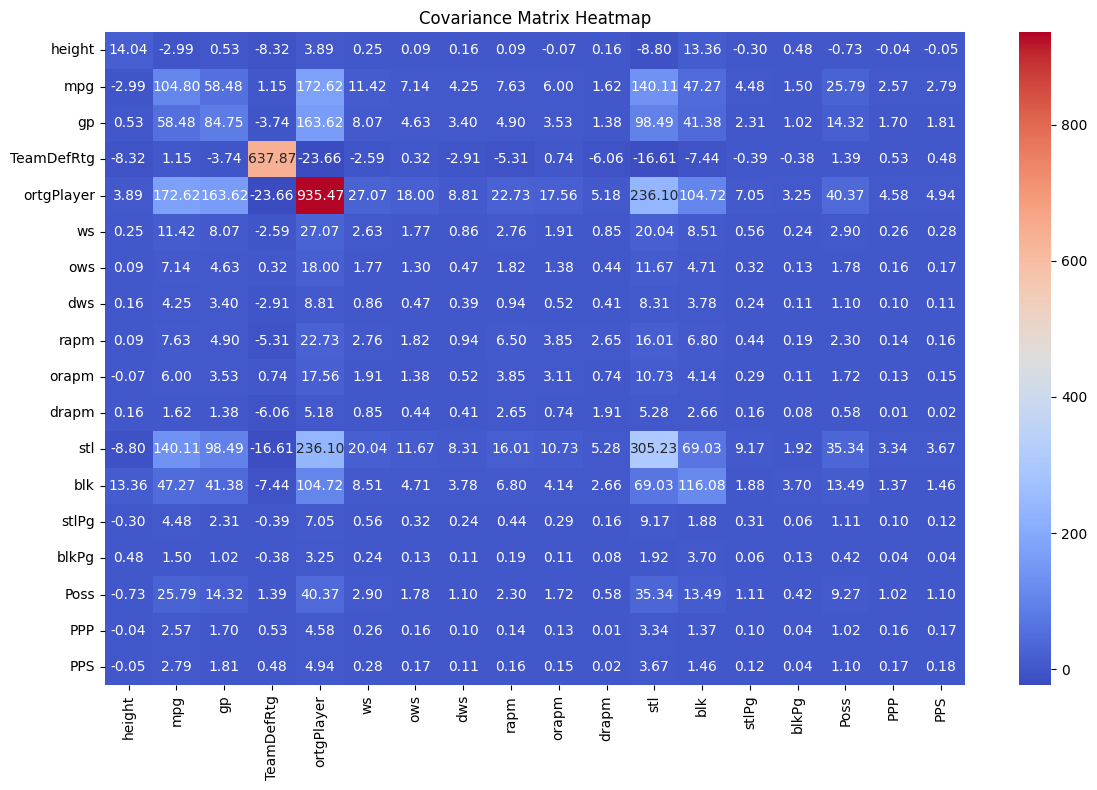

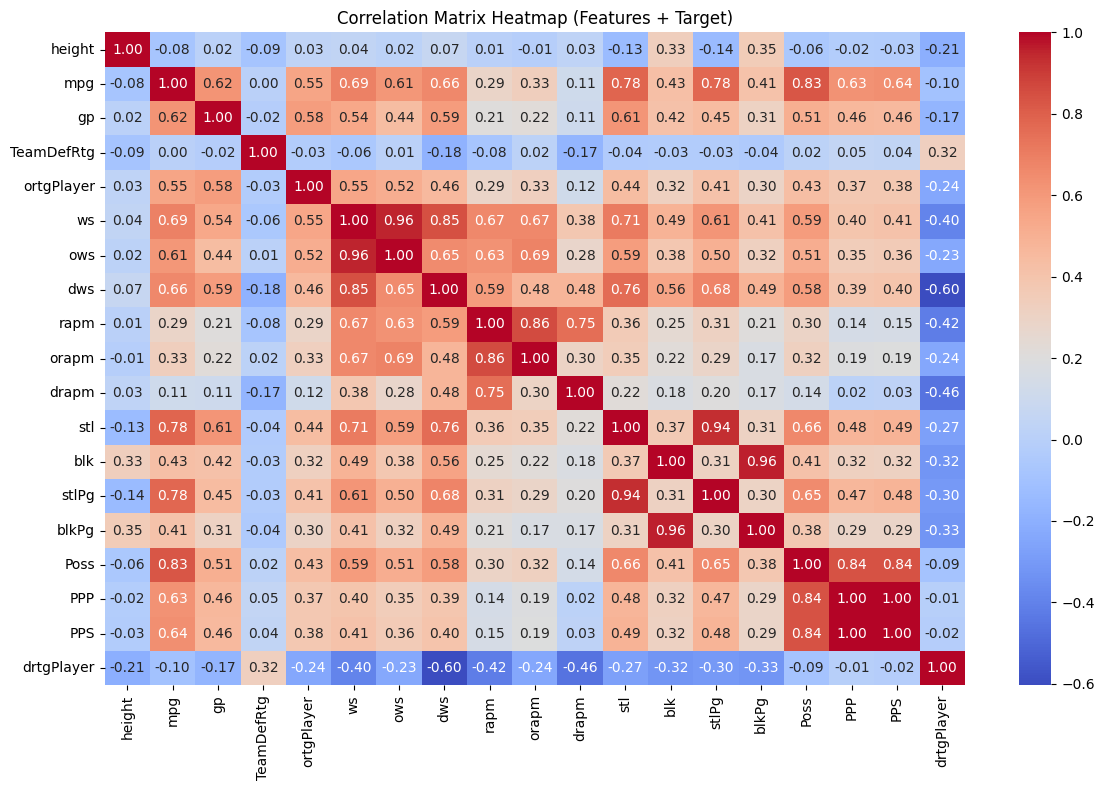

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Covariance matrix heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Covariance Matrix Heatmap")
plt.tight_layout()
plt.show()

# Correlation matrix heatmap (features + target)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix Heatmap (Features + Target)")
plt.tight_layout()
plt.show()

## Multiple Regression

In [18]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_linreg = linreg.predict(X_test)

rmse_linreg = np.sqrt(mean_squared_error(y_test, y_pred_linreg))
r2_linreg = r2_score(y_test, y_pred_linreg)

print(f"Linear Regression RMSE: {rmse_linreg:.2f}")
print(f"Linear Regression R^2 Score: {r2_linreg:.2f}")

Linear Regression RMSE: 3.82
Linear Regression R^2 Score: 0.76


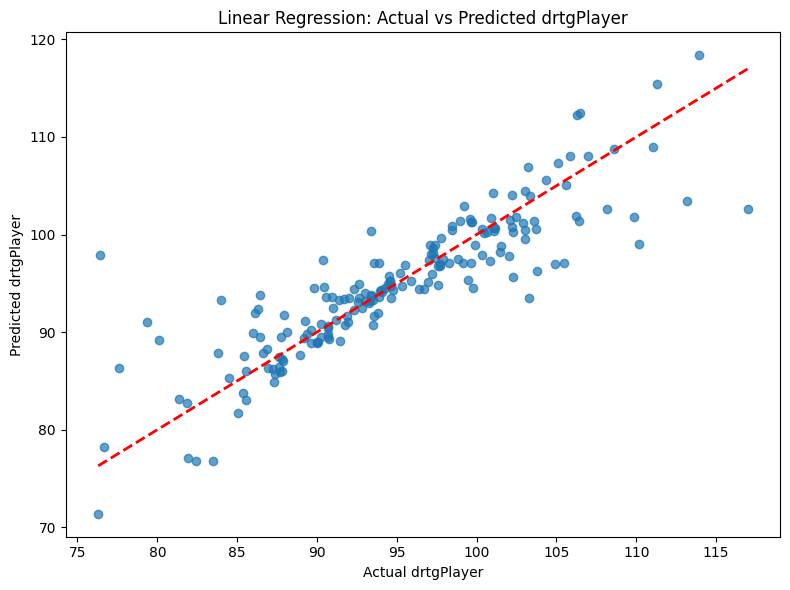

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_linreg, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual drtgPlayer")
plt.ylabel("Predicted drtgPlayer")
plt.title("Linear Regression: Actual vs Predicted drtgPlayer")
plt.tight_layout()
plt.show()

In [25]:
# Print feature importances sorted descending
sorted_indices = importances.argsort()[::-1]
for idx in sorted_indices:
    print(f"{features[idx]}: {importances[idx]:.4f}")

TeamDefRtg: 0.4918
dws: 0.2434
mpg: 0.0498
gp: 0.0403
blkPg: 0.0396
stlPg: 0.0344
ortgPlayer: 0.0204
height: 0.0175
drapm: 0.0112
blk: 0.0084
stl: 0.0077
rapm: 0.0073
orapm: 0.0066
ows: 0.0060
ws: 0.0055
Poss: 0.0047
PPP: 0.0032
PPS: 0.0025


In [22]:
from sklearn.feature_selection import SequentialFeatureSelector

# Forward selection with Linear Regression
sfs = SequentialFeatureSelector(
    LinearRegression(),
    n_features_to_select="auto",  # or set a number, e.g., 5
    direction="backward",
    scoring="r2",
    cv=5,
    n_jobs=-1
)
sfs.fit(X, y)

selected_features = [feature for feature, selected in zip(features, sfs.get_support()) if selected]
print("Selected features by forward selection:", selected_features)

Selected features by forward selection: ['height', 'mpg', 'TeamDefRtg', 'ortgPlayer', 'ws', 'ows', 'dws', 'stl', 'stlPg']


In [23]:
X_train_sfs = X_train[selected_features]
X_test_sfs = X_test[selected_features]



linreg = LinearRegression()
linreg.fit(X_train_sfs, y_train)
y_pred_linreg = linreg.predict(X_test_sfs)

rmse_linreg = np.sqrt(mean_squared_error(y_test, y_pred_linreg))
r2_linreg = r2_score(y_test, y_pred_linreg)

print(f"Linear Regression RMSE: {rmse_linreg:.2f}")
print(f"Linear Regression R^2 Score: {r2_linreg:.2f}")


Linear Regression RMSE: 3.86
Linear Regression R^2 Score: 0.75
